<h1>SUMMARY</h1>
<ol type="I">
    <li>DEPENEDENIES ✅</li>
    <li>FUNCTIONS ✅</li>
    <li>DATA UNDERSTANDING ✅</li>
        <ol>
            <li>STATIONARITY ✅</li>
            <li>GAUSSIANITY ✅</li>
            <li>WHITE NOISE ? ✅</li>
            <li>DECORRELATION ✅</li>
        </ol>
    <li>WIENER FILTERING</li>
        <ol>
            <li>INTEREST ✅</li>
            <li>PROOF OF CONCEPT ✅</li>
            <li>FILTER BANK ✅</li>
            <li>EFFECT OF FILTER LENGTH ✅</li>
            <li>NON STATIONARY SIGNAL ? SEGMENTATION ✅</li>
                <ol>
                    <li>FIXED-SIZE WINDOWS ✅</li>
                    <li>ADAPTATIVE SEGMENTATION ✅</li>
                    <li>OVERLAPPING WINDOWS ✅</li>
                </ol>
        </ol>
    <li>PERSONALIZED SOLUTION ✅</li>
</ol>


<h1> I) DEPENDENCIES</h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wave 
from scipy.linalg import toeplitz
from scipy.io.wavfile import write
from scipy.signal import wiener
import IPython.display as ipd
from statsmodels.tsa.stattools import adfuller
from scipy.signal import welch

<h1>II) FUNCTIONS</h1>

In [3]:
def read_audio(path):
    signal = wave.open(path, 'rb')
    signal_data = signal.readframes(-1)
    signal_data = np.frombuffer(signal_data, dtype='int16')
    signal_data = signal_data / np.max(np.abs(signal_data)) 
    return signal_data, signal.getframerate()

In [4]:
def prep(signal, P):
    N = len(signal)
    corr = np.correlate(signal, signal, mode='same') / (N-P+1)
    corr_vec = corr[P:2*P]
    R = toeplitz(corr_vec)
    return R, corr_vec

In [5]:
def train(Rx, corr_vec):
    wopt = np.linalg.solve(Rx, corr_vec)
    return wopt

In [6]:
def process(signal, P, wopt):
    N = len(signal)
    dhat = np.zeros(N)
    Xbuffer = np.zeros(P)
    
    for n in range(N):
        Xbuffer = np.roll(Xbuffer, 1)
        Xbuffer[0] = signal[n]
        dhat[n] = np.dot(wopt, Xbuffer)    
    return dhat

In [7]:
def wiener_filter(signal, data, length=3):
    Rd, data_corr_vec = prep(data, length)
    Rx, signal_corr_vec = prep(signal, length)
    wopt = train(Rx, data_corr_vec)
    return process(signal, length, wopt)    

In [8]:
def export_audio(filename, signal, fs):
    audio = signal.astype('int16')
    write('./audio/'+filename+'.wav', fs, audio)
    print('Audio exported successfully!')

<h1>III) UNDERSTANDING DATA</h1>

#### LOADING SIGNALS

In [9]:
signal1, fs1 = read_audio('./audio/conv1.wav')
signal2, fs2 = read_audio('./audio/conv73.wav')

In [10]:
N = min(len(signal1), len(signal2))
signal1 = signal1[:N]
signal2 = signal2[:N]

In [11]:
display(ipd.Audio(signal1, rate=fs1))

In [12]:
display(ipd.Audio(signal2, rate=fs2))

In [13]:
signal = signal1 + signal2

In [14]:
display(ipd.Audio(signal, rate=fs1))

<h2>III.1) STATIONARITY<h2>

In statistics, unit root test tests whether a time series variable is non-stationary and possesses a unit root. The null hypothesis is generally defined as the presence of a unit root and the alternative hypothesis is either stationarity, trend stationarity or explosive root depending on the test used.

In [15]:
def generate_non_stationary_signal(length=100, trend_strength=0.2):
    time = np.arange(length)
    stationary_component = np.random.normal(0, 1, size=length)
    trend = trend_strength * time
    non_stationary_signal = stationary_component + trend
    return non_stationary_signal

In [16]:
def check_stationarity(signal):
    result = adfuller(signal)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        print('Signal is not stationary')
    else:
        print('Signal is stationary')

In [17]:
non_stationary_signal = generate_non_stationary_signal()

In [18]:
check_stationarity(non_stationary_signal)

ADF Statistic: -0.132515
p-value: 0.946102
Signal is not stationary


In [19]:
check_stationarity(signal)

ADF Statistic: -56.620644
p-value: 0.000000
Signal is stationary


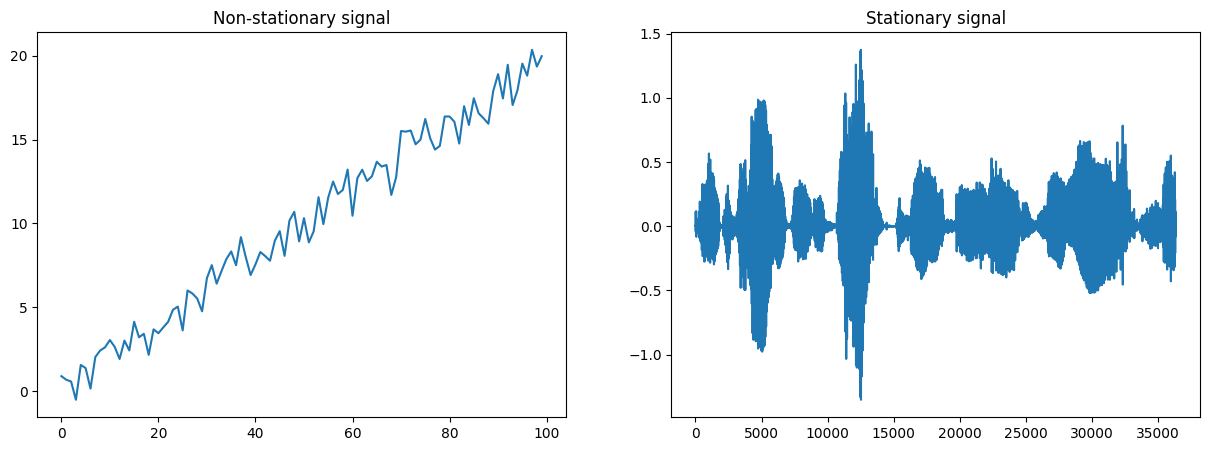

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(non_stationary_signal)
plt.title('Non-stationary signal')
plt.subplot(1, 2, 2)
plt.plot(signal)
plt.title('Stationary signal')

plt.show()

<h2>III.2) GAUSSIANITY</h2>

In [21]:
def check_gaussianity(signal):
    plt.hist(signal, bins='auto')
    plt.show()

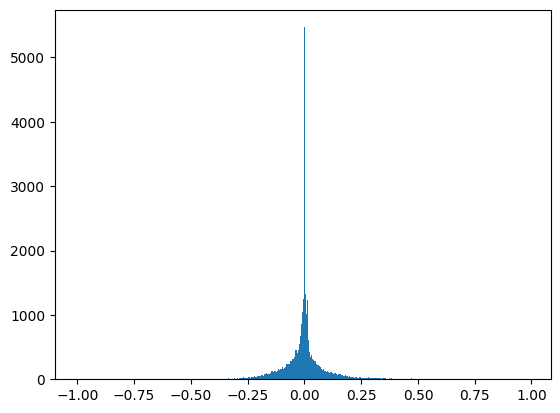

In [22]:
check_gaussianity(signal1)

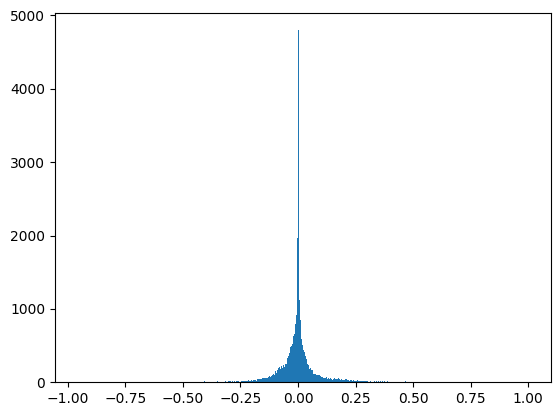

In [23]:
check_gaussianity(signal2)

<h2>III.3) WHITE NOISE ?</h2>

In signal processing, white noise is a random signal having equal intensity at different frequencies, giving it a constant power spectral density.

In [24]:
def plot_psd(signal, fs, title):
    f, Pxx = welch(signal, fs=fs)
    plt.semilogy(f, Pxx)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()

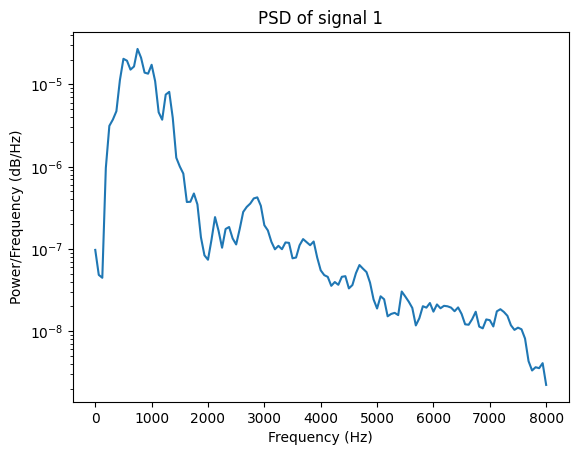

In [25]:
plot_psd(signal1, fs1, 'PSD of signal 1')

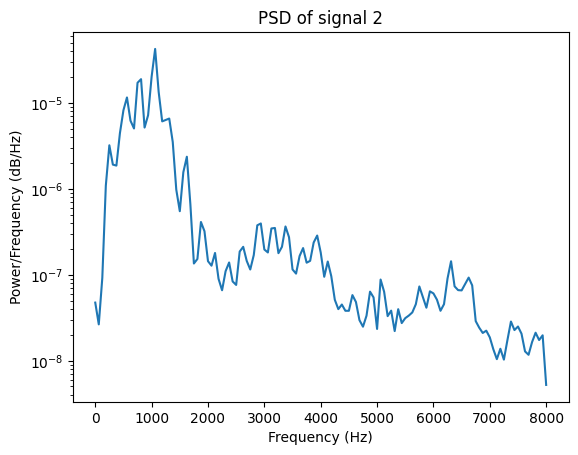

In [26]:
plot_psd(signal2, fs2, 'PSD of signal 2')

INTERPRETATION : 


The Power Spectral Density (PSD) analysis revealed valuable insights into the frequency characteristics of the signal. Contrary to the expectations of white noise, the PSD exhibited spectral peaks indicating dominant frequencies.

<h2>III.4) DECORRELATION</h2>

In [27]:
cross_correlation = np.correlate(signal1, signal2, mode='full')[N-1:]
cross_correlation = cross_correlation / np.max(np.abs(cross_correlation))

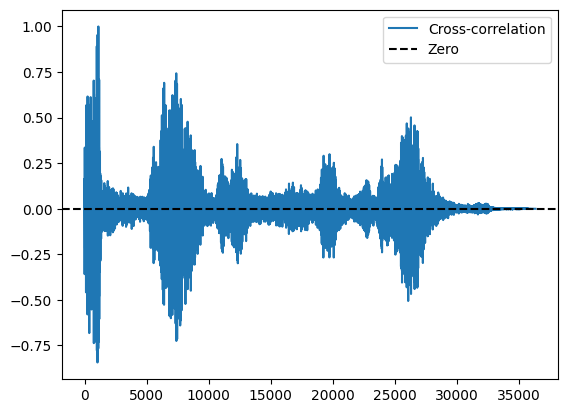

Maximum cross-correlation:  1.0


In [28]:
plt.plot(cross_correlation, label='Cross-correlation')
plt.axhline(0, color='black', linestyle='--', label='Zero')
plt.legend()

plt.show()

max_cross_correlation = np.max(np.abs(cross_correlation))
print('Maximum cross-correlation: ', max_cross_correlation)

<h1>IV) WIENER FILTERING</h1>

<h2>IV.1) INTEREST </h2>

The Wiener filter is a powerful tool in signal processing with various applications due to its ability to enhance the quality of signals in the presence
of noise. 

In [29]:
SNR_apriori = 10 * np.log10(np.var(signal1) / np.var(signal2))

In [30]:
SNR_apriori

0.6246423779698772

ADDING WHITE NOISE TO SIGNAL 1

In [31]:
white_noise = 0.05*np.random.normal(size=N)

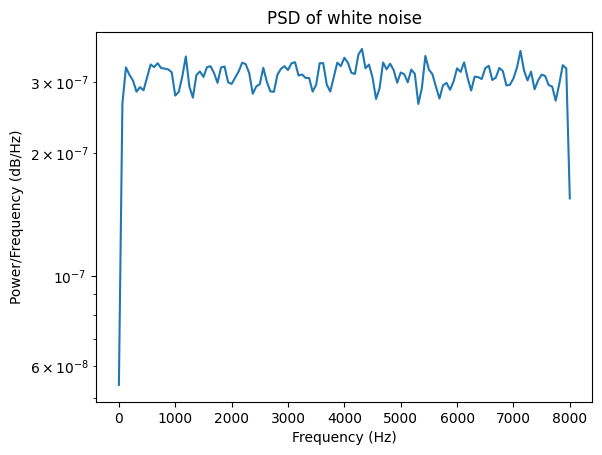

In [32]:
plot_psd(white_noise, fs1, 'PSD of white noise')

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 4.000e+00,
        2.000e+00, 1.000e+00, 6.000e+00, 2.000e+00, 2.000e+00, 1.100e+01,
        1.500e+01, 1.400e+01, 2.700e+01, 2.900e+01, 3.600e+01, 4.000e+01,
        5.300e+01, 5.700e+01, 7.800e+01, 8.500e+01, 8.800e+01, 1.260e+02,
        1.450e+02, 1.890e+02, 2.020e+02, 2.420e+02, 2.810e+02, 3.190e+02,
        3.290e+02, 4.060e+02, 4.500e+02, 4.900e+02, 5.210e+02, 5.880e+02,
        6.580e+02, 7.320e+02, 7.390e+02, 8.090e+02, 8.590e+02, 9.700e+02,
        9.990e+02, 1.043e+03, 1.042e+03, 1.119e+03, 1.129e+03, 1.161e+03,
        1.201e+03, 1.226e+03, 1.152e+03, 1.120e+03, 1.132e+03, 1.101e+03,
        1.081e+03, 1.057e+03, 9.970e+02, 9.360e+02, 9.190e+02, 8.180e+02,
        8.230e+02, 7.690e+02, 6.720e+02, 5.650e+02, 5.900e+02, 5.710e+02,
        4.690e+02, 4.140e+02, 3.880e+02, 3.220e+02, 2.800e+02, 2.290e+02,
        2.290e+02, 1.900e+02, 1.470e+0

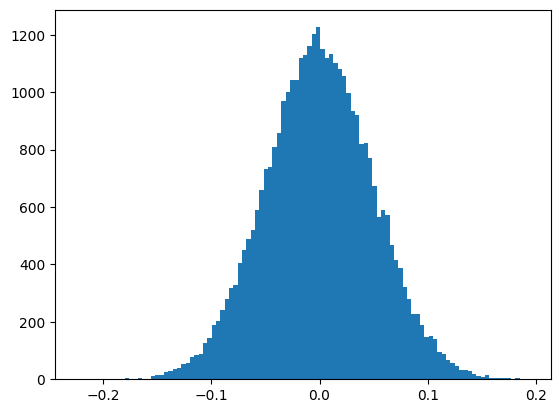

In [33]:
plt.hist(white_noise, bins='auto')

In [34]:
sig1_noise = signal1 + white_noise

In [35]:
display(ipd.Audio(signal1, rate=fs1))

In [36]:
display(ipd.Audio(sig1_noise, rate=fs1))

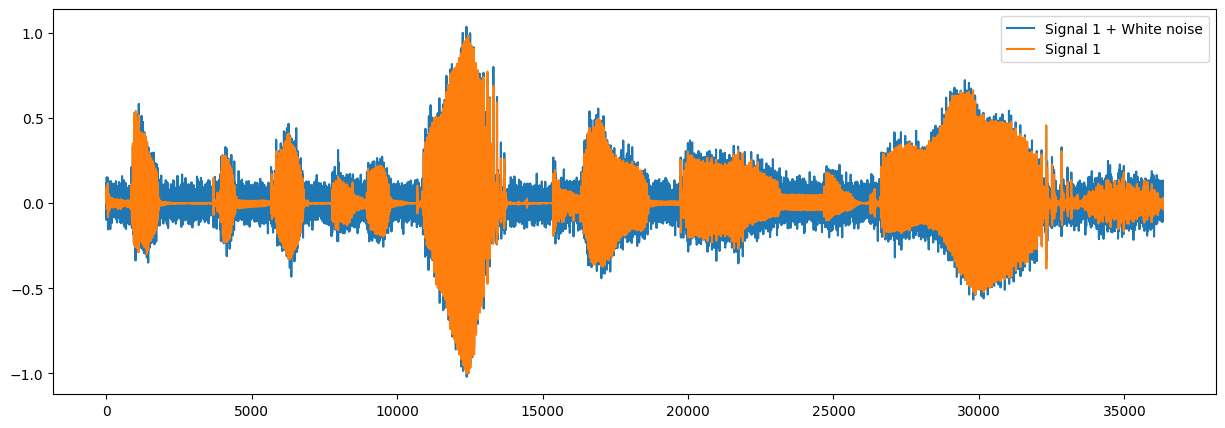

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(sig1_noise, label='Signal 1 + White noise')
plt.plot(signal1, label='Signal 1')
plt.legend()

plt.show()

<h2>IV.2) PROOF OF CONCEPT</h2>

In [38]:
SNR_apriori = 10 * np.log10(np.mean(sig1_noise**2) / np.mean(white_noise**2))

In [39]:
SNR_apriori

8.413340996526609

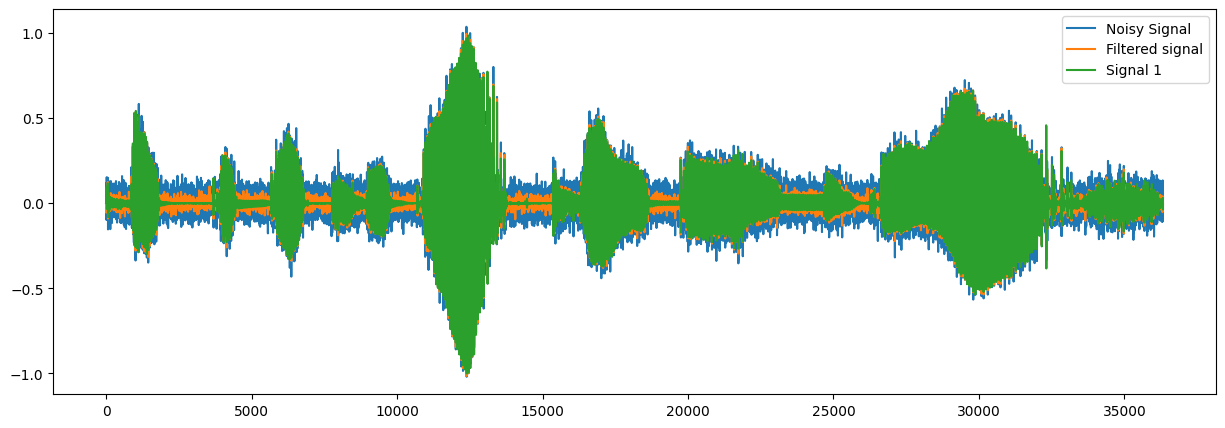

In [55]:
filtered_signal = wiener(sig1_noise, mysize=5, noise=np.abs(white_noise)**2)

plt.figure(figsize=(15, 5))
plt.plot(sig1_noise, label='Noisy Signal')
plt.plot(filtered_signal, label='Filtered signal')
plt.plot(signal1, label='Signal 1')
plt.legend()

plt.show()

In [56]:
SNR_apos = 10 * np.log10(np.mean(filtered_signal**2) / np.mean((signal1 - filtered_signal)**2))
print('SNR a posteriori: ', SNR_apos)

SNR a posteriori:  13.470090793600583


In [57]:
Gain_SNR = SNR_apos - SNR_apriori
print('Gain in SNR: ', Gain_SNR)

Gain in SNR:  5.056749797073975


In [58]:
EQMmin = np.mean((signal1 - filtered_signal)**2)
print('Minimum EQM: ', EQMmin)

Minimum EQM:  0.0006559455279819954


In [59]:
display(ipd.Audio(sig1_noise, rate=fs1))
display(ipd.Audio(filtered_signal, rate=fs1))

<h2>IV.3) FILTER BANK</h2>

    1. FILTER 2

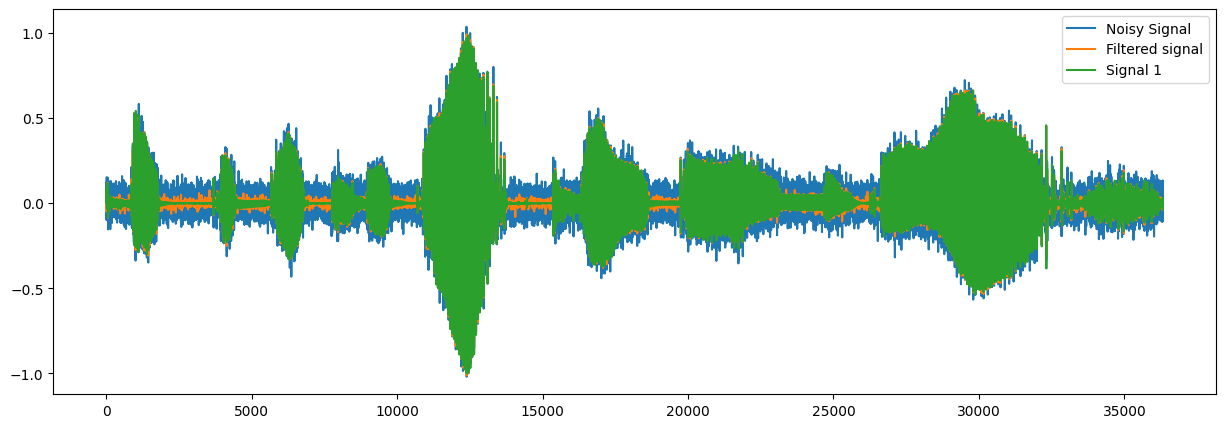

In [60]:
filtered_signal = wiener(filtered_signal, mysize=5, noise=np.abs(filtered_signal - signal1)**2)

plt.figure(figsize=(15, 5))
plt.plot(sig1_noise, label='Noisy Signal')
plt.plot(filtered_signal, label='Filtered signal')
plt.plot(signal1, label='Signal 1')
plt.legend()

plt.show()

In [61]:
SNR_apos1 = 10 * np.log10(np.mean(filtered_signal**2) / np.mean((signal1 - filtered_signal)**2))
Gain_SNR = SNR_apos1 - SNR_apriori

In [62]:
Gain_SNR

5.748083028944327

In [63]:
EQMmin1 = np.mean((signal1 - filtered_signal)**2)
print('Minimum EQM: ', EQMmin1)

Minimum EQM:  0.0005404017348891428


In [64]:
display(ipd.Audio(filtered_signal, rate=fs1))

    2. FILTER 3

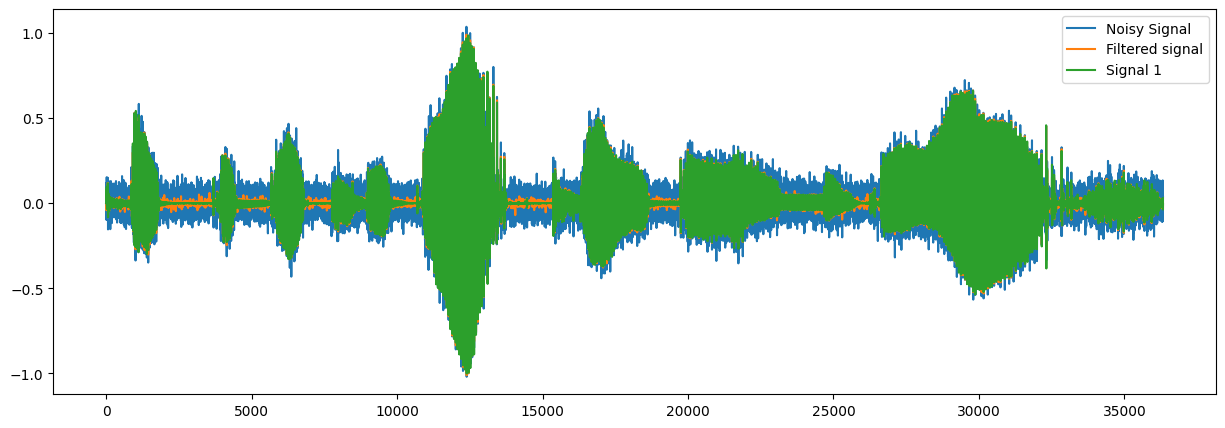

In [65]:
filtered_signal = wiener(filtered_signal, mysize=5, noise=np.abs(filtered_signal - signal1)**2)

plt.figure(figsize=(15, 5))
plt.plot(sig1_noise, label='Noisy Signal')
plt.plot(filtered_signal, label='Filtered signal')
plt.plot(signal1, label='Signal 1')
plt.legend()

plt.show()

    INTERPRETATION : 
    
    The filtered signal is getting closer to the actual signal after each iteration

In [66]:
SNR_apos2 = 10 * np.log10(np.mean(filtered_signal**2) / np.mean((signal1 - filtered_signal)**2))
Gain_SNR = SNR_apos2 - SNR_apriori

In [67]:
Gain_SNR

5.551435189052807

In [68]:
EQMmin = np.mean((signal1 - filtered_signal)**2)
print('Minimum EQM: ', EQMmin)

Minimum EQM:  0.0005536863092488224


In [69]:
display(ipd.Audio(sig1_noise, rate=fs1))
display(ipd.Audio(filtered_signal, rate=fs1))

#### METRICS

In [70]:
filtered_signal = wiener(sig1_noise, mysize=5, noise=np.abs(white_noise)**2)
Gain = []
EQM = []
SNR_apos = 10 * np.log10(np.mean(filtered_signal**2) / np.mean((signal1 - filtered_signal)**2))
Gain_SNR = SNR_apos - SNR_apriori
Gain.append(Gain_SNR)
EQM.append(np.mean((signal1 - filtered_signal)**2))

for i in range(10):
    filtered_signal = wiener(filtered_signal, mysize=5, noise=np.abs(white_noise)**2)
    SNR_apos = 10 * np.log10(np.mean(filtered_signal**2) / np.mean((signal1 - filtered_signal)**2))
    Gain_SNR = SNR_apos - SNR_apriori
    Gain.append(Gain_SNR)
    EQM.append(np.mean((signal1 - filtered_signal)**2))

SIGNAL TO NOISE RATIO (<b>SNR</b>)

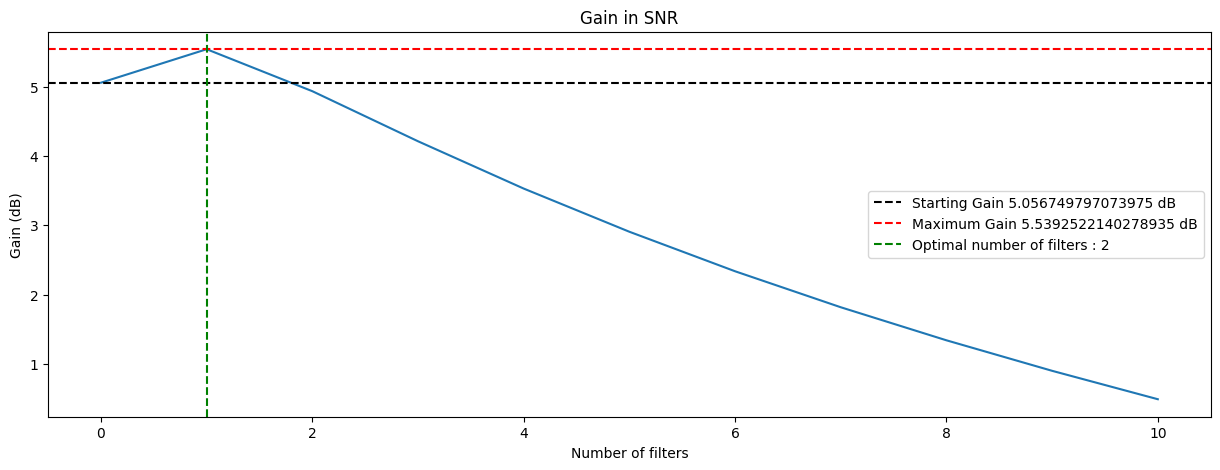

Maximum Gain:  5.5392522140278935
After applying a cascade of 2 Wiener Filters, the maximum gain is achieved


In [71]:
plt.figure(figsize=(15, 5))

plt.plot(Gain)  
plt.axhline(Gain[0], color='black', linestyle='--', label=f'Starting Gain {Gain[0]} dB')
plt.axhline(np.max(Gain), color='red', linestyle='--', label=f'Maximum Gain {np.max(Gain)} dB')
plt.axvline(np.argmax(Gain), color='green', linestyle='--', label=f'Optimal number of filters : {np.argmax(Gain) + 1}')
plt.legend()
plt.title('Gain in SNR')
plt.xlabel('Number of filters')
plt.ylabel('Gain (dB)')

plt.show()

print("Maximum Gain: ", np.max(Gain))
print("After applying a cascade of "+ str(np.argmax(Gain) + 1) + " Wiener Filters, the maximum gain is achieved")

MINIMUN MEAN SQUARE ERROR (<b>MMSE</b>)

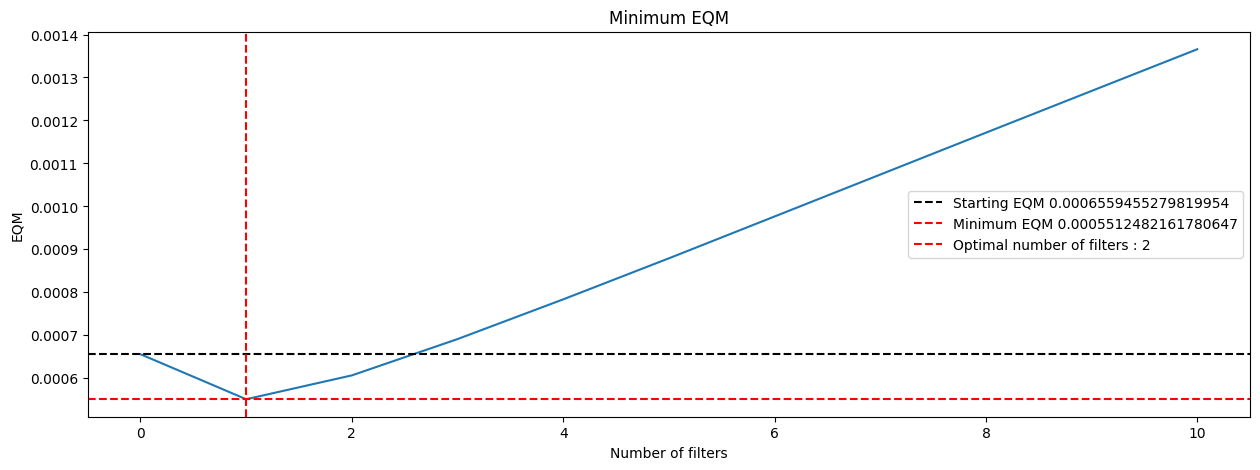

Minimum EQM:  0.0005512482161780647
After applying a cascade of 2 Wiener Filters, the minimum EQM is achieved


In [72]:
plt.figure(figsize=(15, 5))

plt.plot(EQM)
plt.axhline(EQM[0], color='black', linestyle='--', label=f'Starting EQM {EQM[0]}')
plt.axhline(np.min(EQM), color='red', linestyle='--', label=f'Minimum EQM {np.min(EQM)}')
plt.axvline(np.argmin(EQM), color='red', linestyle='--', label=f'Optimal number of filters : {np.argmin(EQM) + 1}')
plt.legend()
plt.title('Minimum EQM')
plt.xlabel('Number of filters')
plt.ylabel('EQM')

plt.show()

print("Minimum EQM: ", np.min(EQM))
print("After applying a cascade of "+ str(np.argmin(EQM) + 1) + " Wiener Filters, the minimum EQM is achieved")

In [73]:
print(((EQM[0] - np.min(EQM))/EQM[0] )*100)

15.96128143841915


    INTERPRETATION:

        - After applying 3 wiener filters, The filtered signal starts to lose information 🛑
        - The cascade of 3 Wiener Filters successfully made us gain around 15% in terms of distance ✅

In [74]:
display(ipd.Audio(sig1_noise, rate=fs1))
display(ipd.Audio(filtered_signal, rate=fs1))

<h2>IV.4) EFFECT OF FILTER LENGTH</h2>

In [75]:
SNR_apriori = 10 * np.log10(np.mean(signal1**2) / np.mean(white_noise**2))
SNR_apriori

7.758944865079046

In [76]:
Gains = []
signals = []
EQMs = []
for order in range(2,10):
    filtered_signal = wiener(sig1_noise, mysize=order)
    SNR_apos = 10 * np.log10(np.mean(filtered_signal**2) / np.mean((signal1 - filtered_signal)**2))
    Gains.append(SNR_apos - SNR_apriori)
    EQMs.append(np.mean((signal1 - filtered_signal)**2))
    signals.append(filtered_signal)

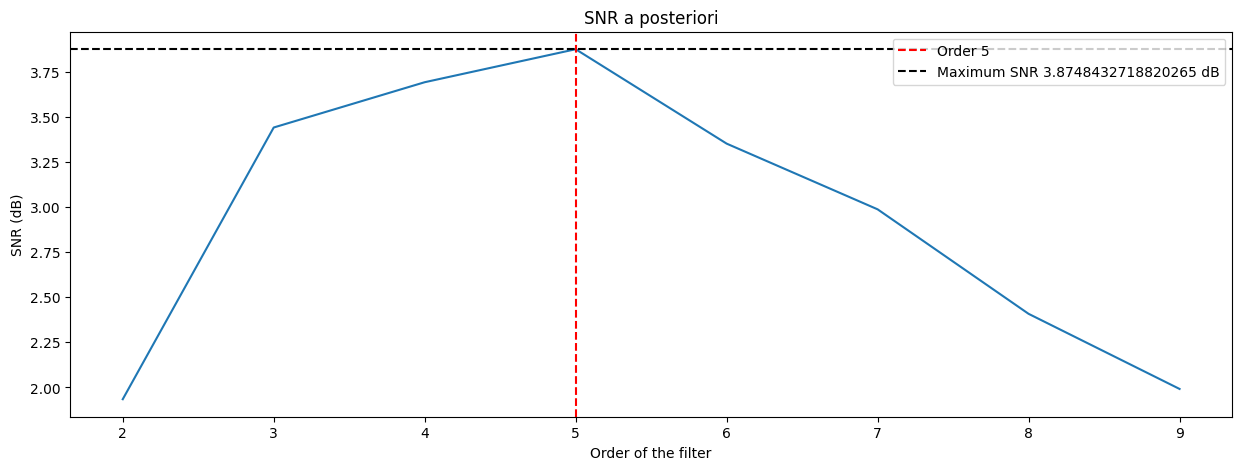

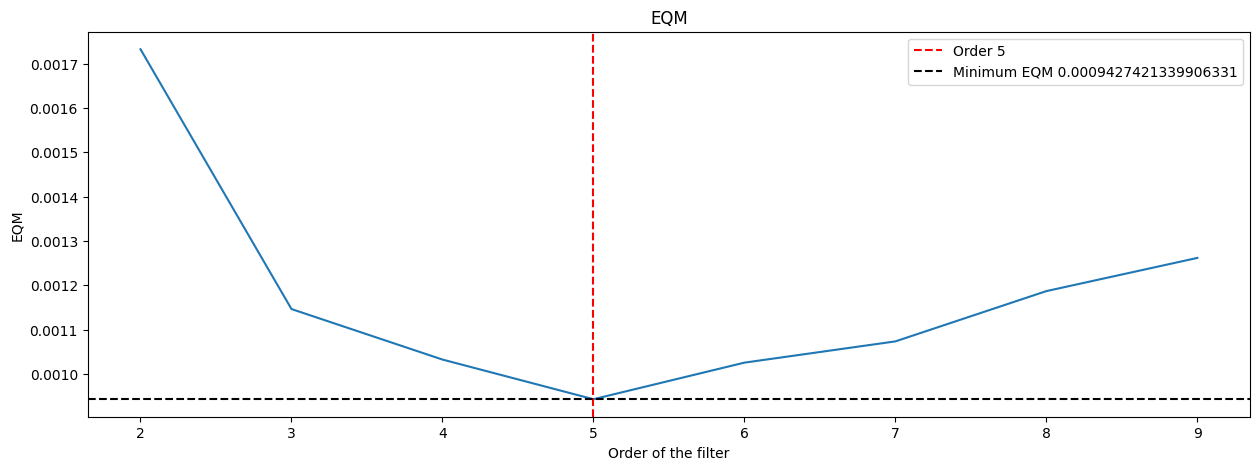

In [77]:
plt.figure(figsize=(15, 5))
plt.plot(range(2,10), Gains)
plt.title('SNR a posteriori')
plt.xlabel('Order of the filter')
plt.ylabel('SNR (dB)')
plt.axvline(np.argmax(Gains) + 2, color='red', linestyle='--', label=f'Order {np.argmax(Gains) + 2}')
plt.axhline(np.max(Gains), color='black', linestyle='--', label=f'Maximum SNR {np.max(Gains)} dB')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(range(2,10), EQMs)
plt.title('EQM')
plt.xlabel('Order of the filter')
plt.ylabel('EQM')
plt.axvline(np.argmin(EQMs) + 2, color='red', linestyle='--', label=f'Order {np.argmin(EQMs) + 2}')
plt.axhline(np.min(EQMs), color='black', linestyle='--', label=f'Minimum EQM {np.min(EQMs)}')
plt.legend()
plt.show()

- Using narrow filter windows makes the filter more <b>sensitive</b> to rapid changes :  
=> This high sensitivity can result in the extraction of noise components along with the signal of interest, leading to a less accurate representation.
<br>=> LOW VALUES OF SNR

- Using wide filter windows makes the filter less effective in detecting tansient features in the signal :
<br>=> Wide window filters result in increased <b>smoothing</b> of the signal : leads to the loss of important signal details, especially in signals with rapid variations


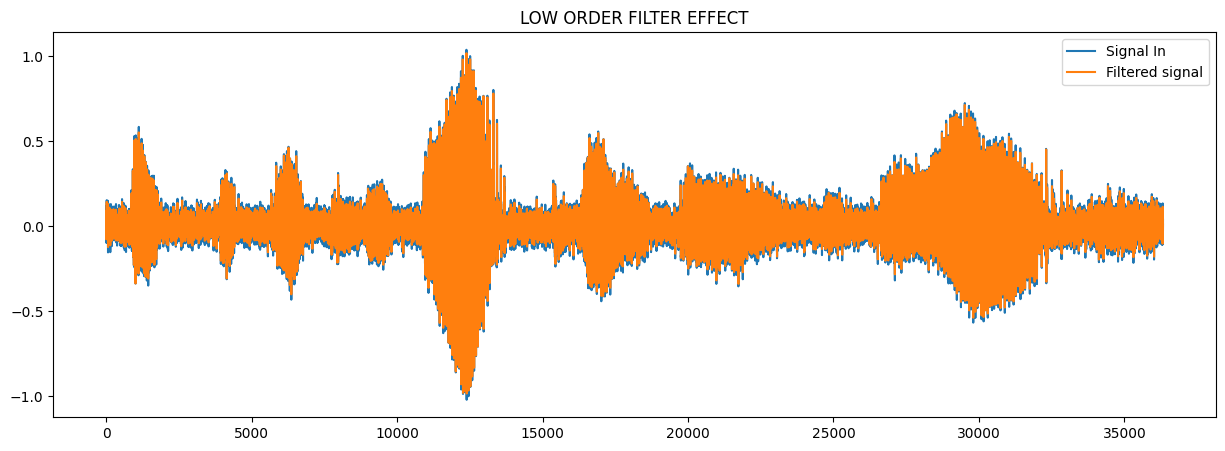

In [78]:
plt.figure(figsize=(15, 5))
plt.plot(sig1_noise, label='Signal In')
plt.plot(signals[0], label='Filtered signal')
plt.legend()
plt.title("LOW ORDER FILTER EFFECT")
plt.show()

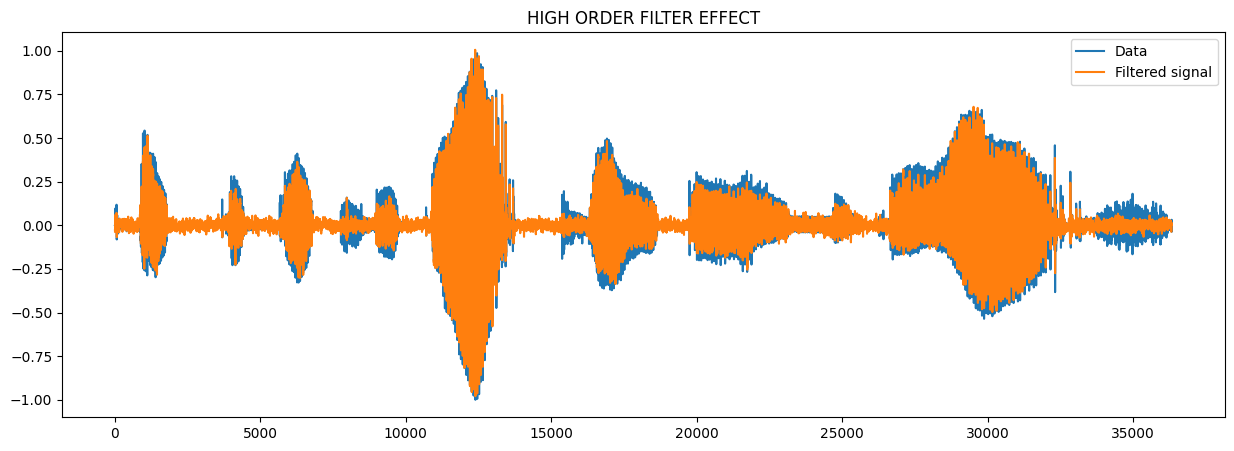

In [79]:
plt.figure(figsize=(15, 5))
plt.plot(signal1, label='Data')
plt.plot(signals[-1], label='Filtered signal')
plt.legend()
plt.title("HIGH ORDER FILTER EFFECT")
plt.show()

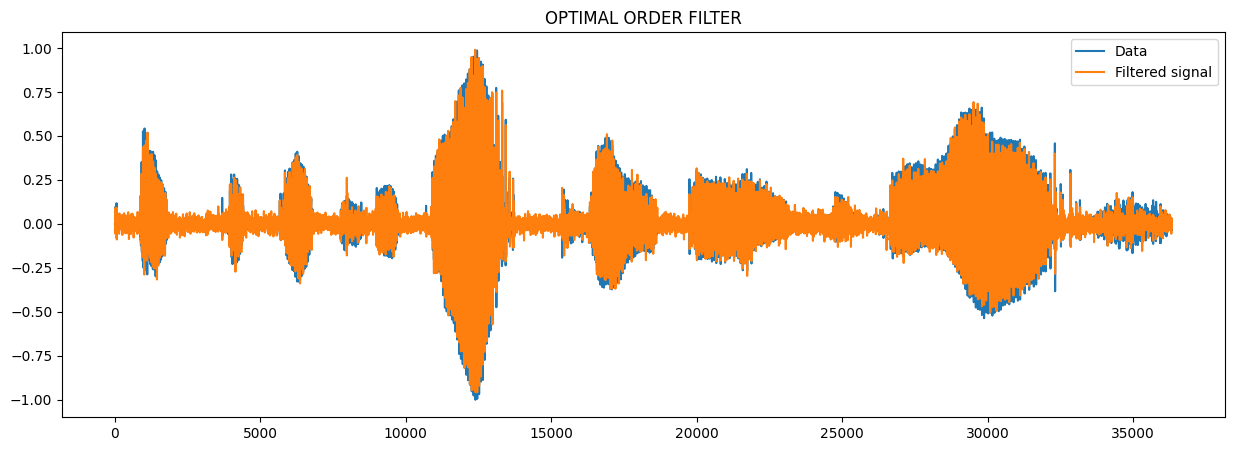

In [80]:
plt.figure(figsize=(15, 5))
plt.plot(signal1, label='Data')
plt.plot(signals[np.argmax(Gains)], label='Filtered signal')
plt.legend()
plt.title("OPTIMAL ORDER FILTER")
plt.show()

<h2>IV.5) NON STATIONARY SIGNAL ? SEGMENTATION</h2>

Segmenting the signal allows the Wiener filter to adapt to local characteristics and variations, enhancing its ability to capture and suppress noise in different parts of the signal.

<h3>IV.5.1) FIXED-SIZE WINDOWS</h3>

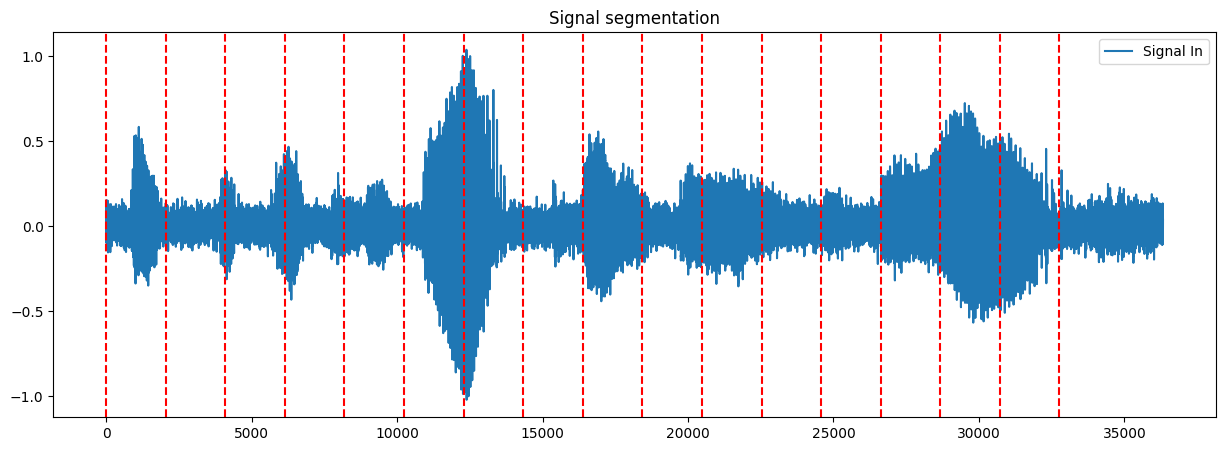

In [81]:
segment_size = 2048
n_segments = len(sig1_noise) // segment_size
limits = np.arange(0, n_segments) * segment_size
plt.figure(figsize=(15, 5))
plt.plot(sig1_noise, label='Signal In')
for limit in limits:
    plt.axvline(limit, color='red', linestyle='--')
plt.title('Signal segmentation')
plt.legend()
plt.show()

In [82]:
def fixed_size_window_segmentation(signal, segment_size):
    num_segments = len(signal) // segment_size
    filtered_segments = np.zeros_like(signal)
    for i in range(num_segments):
        start_idx = i * segment_size
        end_idx = (i + 1) * segment_size
        segment = signal[start_idx:end_idx]
        filtered_segment = wiener(segment)
        filtered_segments[start_idx:end_idx] = filtered_segment
    return filtered_segments

In [83]:
SNR_apriori = 10 * np.log10(np.mean(signal1**2) / np.mean(white_noise**2))
SNR_apriori

7.758944865079046

In [84]:
segment_size = 512
filtered_signal = fixed_size_window_segmentation(sig1_noise, segment_size)

In [85]:
SNR_apos = 10 * np.log10(np.mean(filtered_signal**2) / np.mean((signal1 - filtered_signal)**2))
SNR_apos

10.883071453651027

In [86]:
display(ipd.Audio(sig1_noise, rate=fs1))
display(ipd.Audio(filtered_signal, rate=fs1))

In [87]:
sizes = [2**n for n in range(5, 16)]
SEG_SNR = []
SEG_EQM = []
for size in sizes:
    filtered_signal = fixed_size_window_segmentation(sig1_noise, size)
    SEG_SNR.append(10 * np.log10(np.mean(filtered_signal**2) / np.mean((signal1 - filtered_signal)**2)))
    SEG_EQM.append(np.mean((signal1 - filtered_signal)**2))

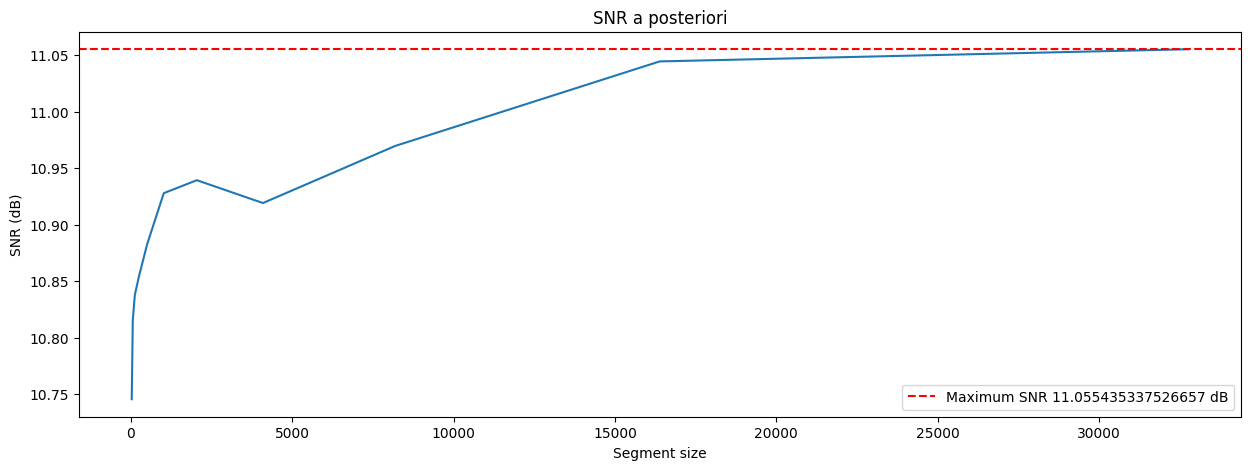

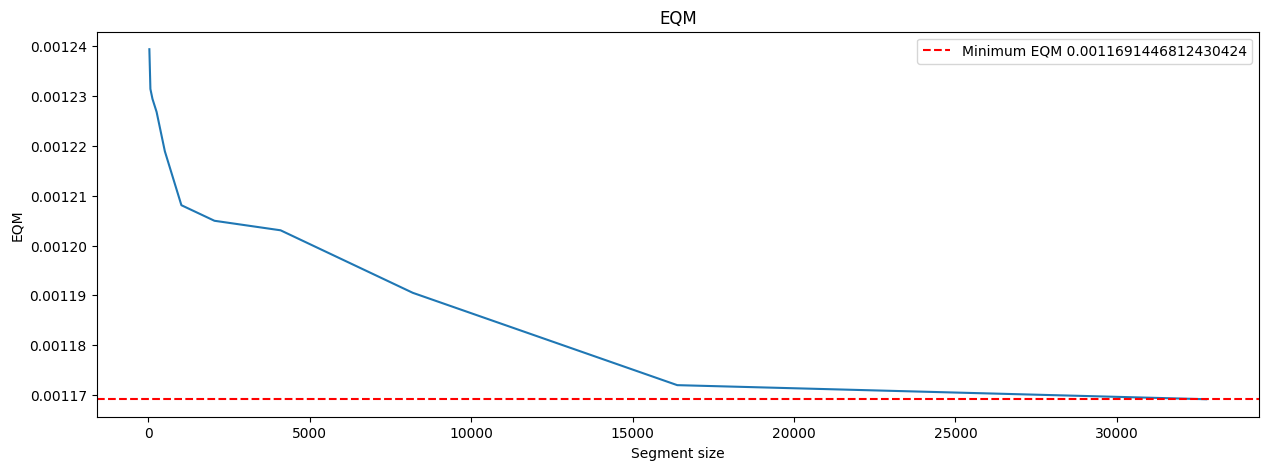

In [88]:
plt.figure(figsize=(15, 5))
plt.plot(sizes, SEG_SNR)
plt.axhline(np.max(SEG_SNR), color='red', linestyle='--', label=f'Maximum SNR {np.max(SEG_SNR)} dB')
plt.title('SNR a posteriori')
plt.xlabel('Segment size')
plt.ylabel('SNR (dB)')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(sizes, SEG_EQM)
plt.axhline(np.min(SEG_EQM), color='red', linestyle='--', label=f'Minimum EQM {np.min(SEG_EQM)}')
plt.title('EQM')
plt.xlabel('Segment size')
plt.ylabel('EQM')
plt.legend()
plt.show()

INTERPRETATION:
<br>The signal's stationnarity is verified since the 1st chapter of this document => The same statistical properties are maintained for whole signal. 

<h3>IV.5.2) ADAPTATIVE SEGMENTATION</h3>
ELECTROENCEPHALOGRAPHY(<b>EEG</b>) PROCESSING
<a>https://backend.orbit.dtu.dk/ws/files/4497320/Simon.pdf</a>

<h3>IV.5.3) OVERLAPPING WINDOWS</h3>

=> Overlapping helps reduce edge effects, and spectral leakage.
<br>- <b>Edge effects</b>, also known as windowing artifacts, are distortions that can occur at the boundaries of signal segments when applying window functions.
<br>These effects are particularly relevant when working with finite-duration segments of a continuous signal.
<br>- <b>Spectral Leakage</b> occurs when the frequency content of a signal extends beyond the boundaries of a window.</b>

In [89]:
SNR_apriori = 10 * np.log10(np.mean(sig1_noise**2) / np.mean(white_noise**2))
SNR_apriori

8.413340996526609

In [90]:
def segmentation_with_overlap(signal, window_size=512, overlap_ratio=0.5):
    overlap_size = int(window_size * overlap_ratio)
    filtered_segments = []
    start_indexes = []

    for i in range(0, len(signal) - window_size + 1, window_size - overlap_size):
        start_idx = i
        end_idx = i + window_size
        segment = signal[start_idx:end_idx]
        filtered_segment = wiener(segment)
        filtered_segments.append(filtered_segment)
        start_indexes.append(start_idx)

    filtered_signal = np.concatenate(filtered_segments[:1] + [filtered_segments[i][overlap_size:] for i in range(1, len(filtered_segments))])
    return filtered_signal, start_indexes

In [91]:
overlap_filtered_signal, start_indexes = segmentation_with_overlap(sig1_noise, window_size=512, overlap_ratio=0.5)

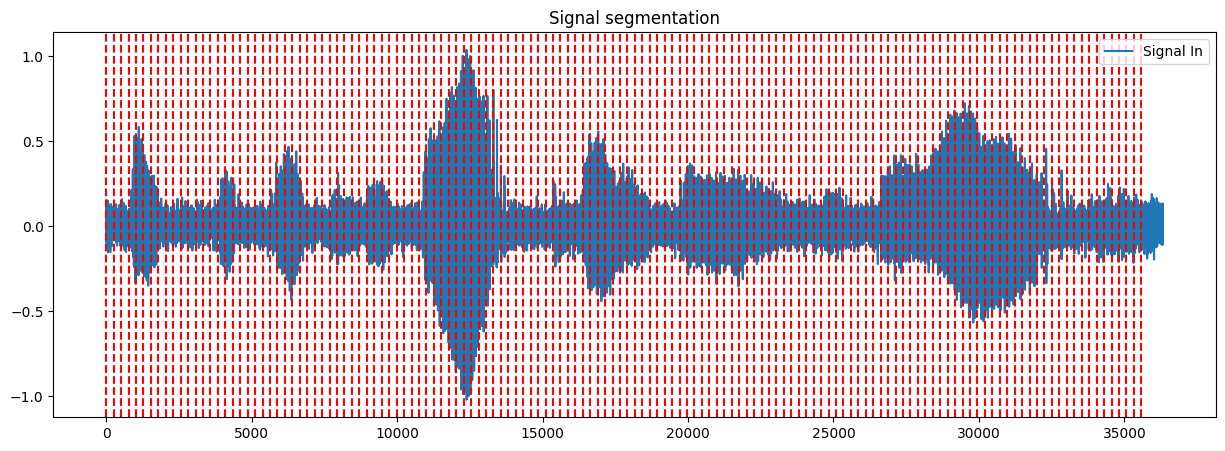

In [92]:
plt.figure(figsize=(15, 5))
plt.plot(sig1_noise, label='Signal In')
for start_idx in start_indexes:
    plt.axvline(start_idx, color='red', linestyle='--')
plt.title('Signal segmentation')
plt.legend()
plt.show()

In [93]:
display(ipd.Audio(sig1_noise, rate=fs1))
display(ipd.Audio(overlap_filtered_signal, rate=fs1))

In [94]:
SNR_apos = 10 * np.log10(np.mean(overlap_filtered_signal**2) /
                         np.mean((signal1[:len(overlap_filtered_signal)] - overlap_filtered_signal)**2))


SNR_apos

10.88413275085027

In [96]:
overlap_filtered_signal, start_indexes = segmentation_with_overlap(overlap_filtered_signal, window_size=512, overlap_ratio=0.5)
SNR_apos = 10 * np.log10(np.mean(overlap_filtered_signal**2) / np.mean((signal1[:len(overlap_filtered_signal)] - overlap_filtered_signal)**2))
SNR_apos

11.130301949371006

<h2>IV.6) SOURCE SEPARATION</h2>

In [14]:
display(ipd.Audio(signal, rate=fs1))

In [15]:
SNR1_apriori = 10*np.log10(np.mean(signal1**2)/np.mean(signal2**2))
SNR2_apriori = 10*np.log10(np.mean(signal2**2)/np.mean(signal1**2))
print('SNR1 apriori: ', SNR1_apriori)
print('SNR2 apriori: ', SNR2_apriori)

SNR1 apriori:  0.6246423600025764
SNR2 apriori:  -0.6246423600025762


==> SNR IS SO LOW !! BAD SEPARATION

In [16]:
d1hat = wiener_filter(signal, signal1, length=3)
d2hat = wiener_filter(signal, signal2, length=3)

In [17]:
display(ipd.Audio(d1hat, rate=fs1))
display(ipd.Audio(d2hat, rate=fs1))

In [18]:
def fixed_size_window_segmentation(signal, data, segment_size):
    num_segments = len(signal) // segment_size
    filtered_segments = np.zeros_like(signal)
    for i in range(num_segments):
        start_idx = i * segment_size
        end_idx = (i + 1) * segment_size
        segment = signal[start_idx:end_idx]
        filtered_segment = wiener_filter(segment, data[start_idx:end_idx])
        filtered_segments[start_idx:end_idx] = filtered_segment
    return filtered_segments

In [19]:
def segmentation_with_overlap(signal, data, filter_size, window_size=512, overlap_ratio=0.5):
    overlap_size = int(window_size * overlap_ratio)
    filtered_segments = []

    for i in range(0, len(signal) - window_size + 1, window_size - overlap_size):
        start_idx = i
        end_idx = i + window_size
        segment = signal[start_idx:end_idx]
        filtered_segment = wiener_filter(
            segment, data[start_idx:end_idx], length=filter_size)
        filtered_segments.append(filtered_segment)

    filtered_signal = np.zeros_like(signal)
    for i in range(len(filtered_segments)):
        start_idx = i * (window_size - overlap_size)
        end_idx = start_idx + window_size
        filtered_signal[start_idx:end_idx] = filtered_segments[i]

    return filtered_signal

In [20]:
d1hat_prime = fixed_size_window_segmentation(signal, signal1, segment_size=512)
d2hat_prime = fixed_size_window_segmentation(signal, signal2, segment_size=512)

In [21]:
display(ipd.Audio(d1hat_prime, rate=fs1))
display(ipd.Audio(d2hat_prime, rate=fs1))

In [22]:
d1hat_second = segmentation_with_overlap(
        signal, signal1, 4, window_size=512, overlap_ratio=0.5
    )

In [23]:
d2hat_second = segmentation_with_overlap(
        signal, signal2, 3, window_size=512, overlap_ratio=0.1
    )

In [24]:
display(ipd.Audio(d1hat_second, rate=fs1))
display(ipd.Audio(d2hat_second, rate=fs1))

<h2>IV.7) TEMPORAL FILTERING vs FREQUENCIAL FILTERING</h2>

<h1>V) PERSONALIZED SOLUTION</h1>

<h4>WIENER FILTER</h4>

Inversing Rx is computationally heavy : O(P^3) !!!

<b>Introducing a new method to reduce the complexity to O(P*N) :</b><br>
In addition to the traditional approach of calculating the Wiener filter coefficients through matrix inversion, an alternative methodology involves directly adjusting the weighting of residuals. This method offers a nuanced perspective on the implementation of the Wiener filter, providing an alternative route to achieve optimal denoising.
    
<b>PROCEDURE</b>
- Estimate Local Mean and Local Variance : <br>
Compute the local mean L(n) and local variance V(n) using appropriate filtering techniques. These statistics serve as key parameters for subsequent computations. <br>
- Compute Residuals : <br>
Calculate the residuals res(n) by subtracting the local mean from the observed signal. <br>
- Adjust Residuals Using Weighting Factor : <br>
Introduce a weighting factor that dynamically adjusts the influence of the residuals based on the ratio of the estimated noise power to the local variance.<br>
    - When V(n) (local variance) is significantly larger than the estimated noise, 1− (noise/V(n)) approaches 1, and the residual term is given more weight. This is desirable in regions where the signal dominates over noise. <br>
    - When V(n) is comparable to or smaller than the estimated noise,1− (noise/V(n))​  approaches 0, and the residual term is given less weight. This is advantageous in regions where the noise level is relatively high compared to the local variance. <br>
- Overall Wiener Filter Output : <br>
The Wiener filter combines the local mean and the weighted residual to obtain the final output. The weighted residual acts as a correction to the local mean, and the weight is determined by the ratio of the estimated noise to the local variance.

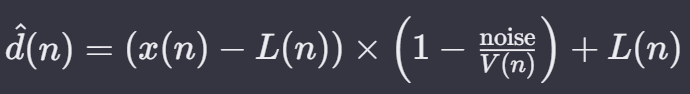

<b>ALGORITHM</b><br>
- lMean = local mean on each segment with the length <b>filter_size</b><br>

- lVar = local variance on each segment with the length <b>filter_size</b><br>

- noise = the estimate power of noise
- if noise is None:<br>
    - noise = mean(Data Variances)<br>

- res = (data - lMean)<br>
- res *= (1 - noise / lVar)<br>
- res += lMean<br>
- out = <br>
    - lMean if lVar < noise <br>
    - res if lVar >= noise<br>

<b>CONSTRAINT !!! SENSITIVITY TO NOISE ESTIMATION</b><br>
The method involves adjusting residuals based on the ratio of the estimated noise power to the local variance. If the noise estimation is unreliable or if the noise power is consistently overestimated, the performance of the method may be compromised.

<hr>

<h4>INDEPENDENT COMPONENT ANALYSIS</h4>

INDEPENDENT COMPONENT ANALYSIS (<b>ICA</b>) is a computational method for separating a multivariate signal into additive subcomponents. This is done by assuming that at most one subcomponent is Gaussian and that the subcomponents are statistically independent from each other.ICA is a special case of blind source separation. A common example application is the "<b>COCKTAIL PARTY PROBLEM</b>" of listening in on one person's speech in a noisy room.<br>
- wikipedia

In [15]:
from sklearn.decomposition import FastICA

In [16]:
s1 = signal1  
s2 = signal2  

S = np.c_[s1, s2]
S /= S.std(axis=0)  

A = np.array([[0.5, 0.5],
              [0.7, 0.3]])
X = np.dot(S, A.T)  

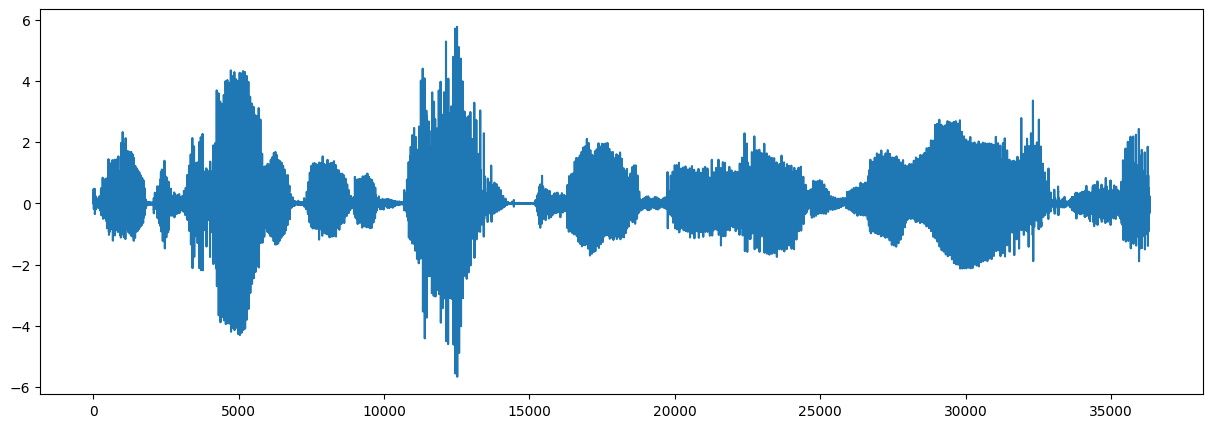

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(X.T[0])

In [18]:
display(ipd.Audio(X.T[0], rate=fs1))

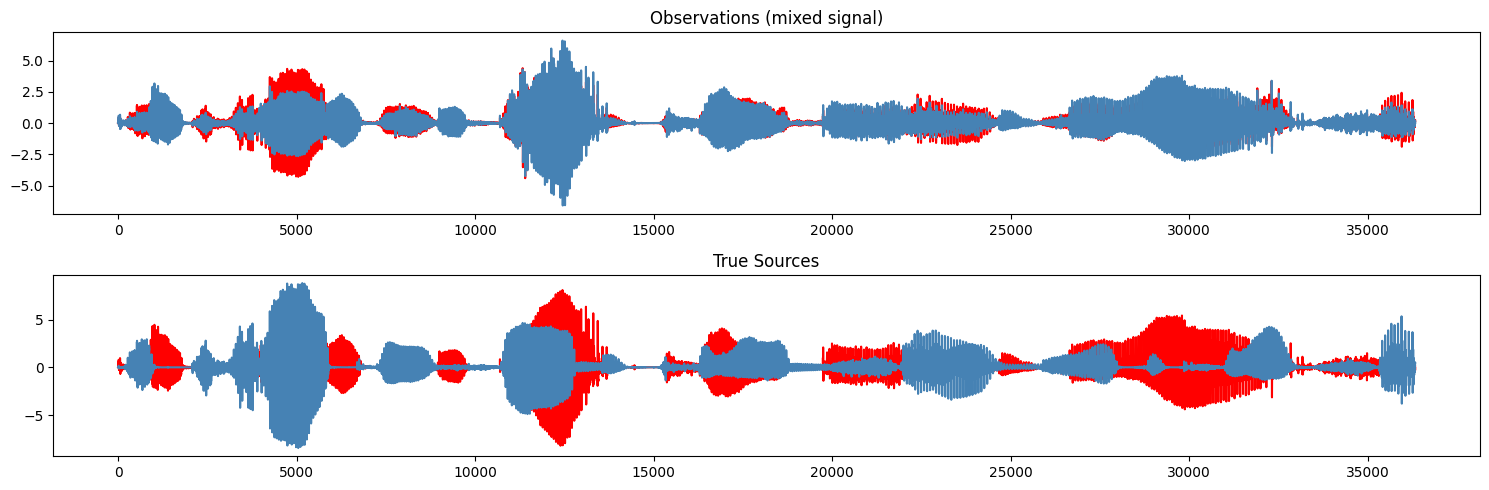

In [20]:
plt.figure(figsize=(15, 5))
models = [X, S]
names = ['Observations (mixed signal)',
         'True Sources']
colors = ['red', 'steelblue']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(2, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

In [21]:
ica = FastICA(n_components=2, whiten="arbitrary-variance")
S_ = ica.fit_transform(X)  
A_ = ica.mixing_  

assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

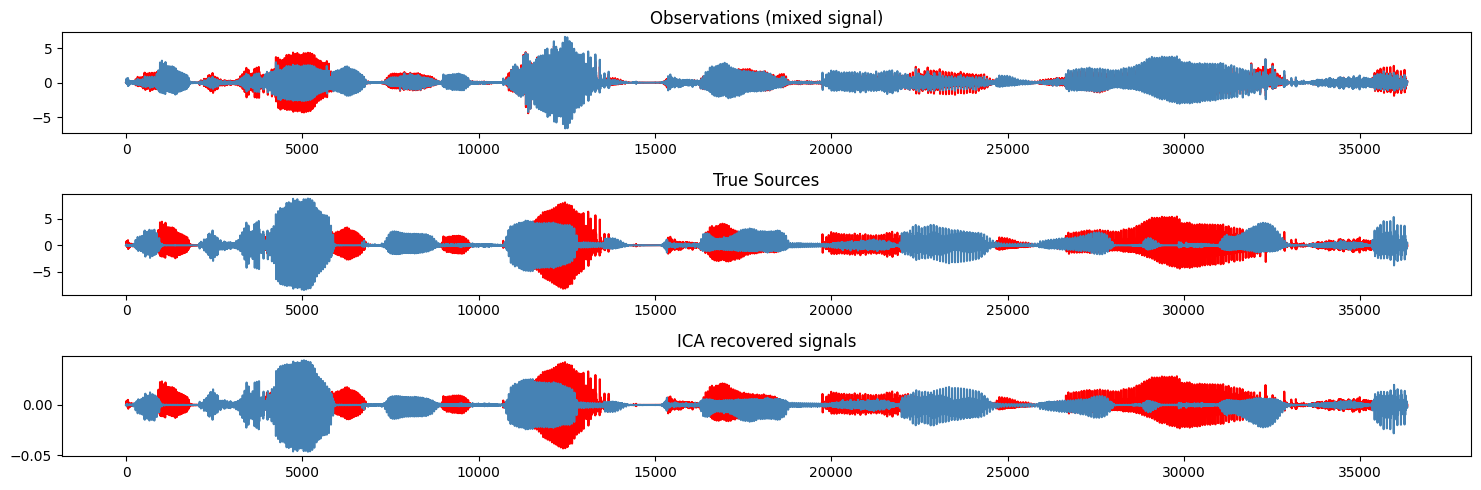

In [22]:
plt.figure(figsize=(15, 5))
models = [X, S, S_]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals']
colors = ['red', 'steelblue']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(3, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

In [21]:
display(ipd.Audio(S_[:, 0], rate=fs1))
display(ipd.Audio(S_[:, 1], rate=fs1))